### Project to build a house prediction algorithm for house prices in bangalore

In [784]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

Set the matplotlib parameter for figure size and turn on in line display

In [785]:
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (20, 10)

Import the SKLearn modules compare linear models to decision trees

In [786]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

Read in the housing price dataset

In [787]:
df = pd.read_csv("./Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


### Exploratory Data Analysis

In [788]:
df.shape

(13320, 9)

In [789]:
# Check the column names and data types - note that total_sqft is not interpreted as numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [790]:
# Print summary statistics for all numerical dimensions of the dataframe
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [791]:
# use include = "all" to decribe all features including categorical
# This will show some categorical statistics i.e. unique values & frequency of the common data
df.describe(include = "all")

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
count,13320,13320,13319,13304,7818,13320,13247.000000,12711.000000,13320.000000
unique,4,81,1305,31,2688,2117,NaN,NaN,NaN
top,Super built-up Area,Ready To Move,Whitefield,2 BHK,GrrvaGr,1200,NaN,NaN,NaN
freq,8790,10581,540,5199,80,843,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.692610,1.584376,112.565627
std,NaN,NaN,NaN,NaN,NaN,NaN,1.341458,0.817263,148.971674
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,8.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,50.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,72.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,2.000000,120.000000


In [792]:
# Count the number of missing values in each column
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [793]:
# Examining area type
df.groupby("area_type")["area_type"].agg("count")

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

Since availability does not effect the house price - the house will cost the same regardless of when the inhabitant is ready to move - we can remove this feature. <br>
Society is missing values for 5.5k observations so, at least for a first pass, we can remove society as this will limit our data after removing null value observations. <br>
Balcony should remain as this could have an effect on house price - rather than drop obeservations with missing balcony information, we can instead examine and input approriate values i.e. null = zero.

In [794]:
# Drop the columns
df = df.drop(['availability', 'society'], axis = "columns")

In [795]:
df.shape

(13320, 7)

In [796]:
df['balcony'].fillna(0, inplace=True)

In [797]:
df.isnull().sum()

area_type      0
location       1
size          16
total_sqft     0
bath          73
balcony        0
price          0
dtype: int64

Now that the balcony NaNs have been converted to zeroes, we can now drop the observations with null values in location, size, bath.

In [798]:
df = df.dropna()

In [799]:
df.shape

(13246, 7)

### Feature Engineering

Examining the size dimension

In [800]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

We can see that every value is in the form r'/d+/s/w+.
With this, we can see that there are 2 different methods of declaring the size of the apartment but for our purposes, just an integer will be sufficient.

In [801]:
df['beds'] = df['size'].apply(lambda x: int(x.split(" ")[0]))

In [802]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13246 entries, 0 to 13319
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area_type   13246 non-null  object 
 1   location    13246 non-null  object 
 2   size        13246 non-null  object 
 3   total_sqft  13246 non-null  object 
 4   bath        13246 non-null  float64
 5   balcony     13246 non-null  float64
 6   price       13246 non-null  float64
 7   beds        13246 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 931.4+ KB


In [803]:
df.head()

,area_type,location,size,total_sqft,bath,balcony,price,beds
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07,2
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00,4
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00,3
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,3
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,1.0,51.00,2


Examining the total_sqft dimension

In [804]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

As we can see by examining both the dataframe information and the unique values, there is a mixture of string and numeric values in the size column.<br>
As a first step towards standardising the format, we need to examine the different ways that size is represented.

In [805]:
# Function to test whether a value is numeric and can be coerced to float
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [806]:
# Apply the function to the total_sqft dimension and filter the result set to show non-numeric values.
df[~df['total_sqft'].apply(is_float)].head(20)

,area_type,location,size,total_sqft,bath,balcony,price,beds
30,Super built-up Area,Yelahanka,4 BHK,2100 - 2850,4.0,0.0,186.000,4
122,Super built-up Area,Hebbal,4 BHK,3067 - 8156,4.0,0.0,477.000,4
137,Super built-up Area,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,0.0,54.005,2
165,Super built-up Area,Sarjapur,2 BHK,1145 - 1340,2.0,0.0,43.490,2
188,Super built-up Area,KR Puram,2 BHK,1015 - 1540,2.0,0.0,56.800,2
410,Super built-up Area,Kengeri,1 BHK,34.46Sq. Meter,1.0,0.0,18.500,1
549,Super built-up Area,Hennur Road,2 BHK,1195 - 1440,2.0,0.0,63.770,2
648,Built-up Area,Arekere,9 Bedroom,4125Perch,9.0,0.0,265.000,9
661,Super built-up Area,Yelahanka,2 BHK,1120 - 1145,2.0,0.0,48.130,2
672,Built-up Area,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,0.0,445.000,4


There are a number of different formats that total_sqft is being represented but essentially there are 2 challenges to processing.<br>
    <li>1. The case where we have 2 numeric values separated using a hyphen.
    <li>2. The case where we have a numeric value followed by text. Note that in this case the unit described in the text is not consistent with sqft. <br><br>
For case 1, we will take each value, split to a pair and find the mean between the 2 values.<br>
For case 2, we will examine the quantity of remaining values and decide whether to process further or just drop from our data for the sake of simplicity.

In [807]:
# Function to split the text into 2 numbers and find the average
def convert_sqft_to_number(x):
    tokens = x.split("-")
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [808]:
# Apply convert_sqft_to_number to the total_sqft column as a first solve for case 1.
df['sqft'] = df['total_sqft'].apply(convert_sqft_to_number)

Examining the newly formed head, we can see that the sqft column has replaced the case 1 values with numerics. <br>
Now we can look a little closer at the case 2 values to determine if more processing if necessary.

In [809]:
df[~df['total_sqft'].apply(is_float)].head(20)

,area_type,location,size,total_sqft,bath,balcony,price,beds,sqft
30,Super built-up Area,Yelahanka,4 BHK,2100 - 2850,4.0,0.0,186.000,4,2475.0
122,Super built-up Area,Hebbal,4 BHK,3067 - 8156,4.0,0.0,477.000,4,5611.5
137,Super built-up Area,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,0.0,54.005,2,1073.5
165,Super built-up Area,Sarjapur,2 BHK,1145 - 1340,2.0,0.0,43.490,2,1242.5
188,Super built-up Area,KR Puram,2 BHK,1015 - 1540,2.0,0.0,56.800,2,1277.5
410,Super built-up Area,Kengeri,1 BHK,34.46Sq. Meter,1.0,0.0,18.500,1,NaN
549,Super built-up Area,Hennur Road,2 BHK,1195 - 1440,2.0,0.0,63.770,2,1317.5
648,Built-up Area,Arekere,9 Bedroom,4125Perch,9.0,0.0,265.000,9,NaN
661,Super built-up Area,Yelahanka,2 BHK,1120 - 1145,2.0,0.0,48.130,2,1132.5
672,Built-up Area,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,0.0,445.000,4,4046.0


In [810]:
missing_sqft = df['sqft'].isnull().sum()
print(f'Number of values: {missing_sqft}, this is {missing_sqft/df.shape[0]:.4f}%')

Number of values: 46, this is 0.0035%


With such a small number of instances, there benefit to developing regex to parse and functions to calculate the sqft value from the various units that were provided will have limited utility. <br> In future iterations, with a larger sample size and increased volume of case 2 values, there may be justification to develop this functionality. <br>For now, we can drop these rows and continue our analysis.

In [811]:
df.dropna(inplace = True)

In [812]:
missing_sqft = df['sqft'].isnull().sum()
print(f'Number of values: {missing_sqft}, this is {missing_sqft/df.shape[0]:.4f}%')

Number of values: 0, this is 0.0000%


All missing values have been dropped from the dataframe.

At this point, we can drop the total_sqft and size dimensions as we have processed these to extract the most useful information.

In [813]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13200 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area_type   13200 non-null  object 
 1   location    13200 non-null  object 
 2   size        13200 non-null  object 
 3   total_sqft  13200 non-null  object 
 4   bath        13200 non-null  float64
 5   balcony     13200 non-null  float64
 6   price       13200 non-null  float64
 7   beds        13200 non-null  int64  
 8   sqft        13200 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.0+ MB


In [814]:
df.drop(['size', 'total_sqft'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13200 entries, 0 to 13319
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   area_type  13200 non-null  object 
 1   location   13200 non-null  object 
 2   bath       13200 non-null  float64
 3   balcony    13200 non-null  float64
 4   price      13200 non-null  float64
 5   beds       13200 non-null  int64  
 6   sqft       13200 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 825.0+ KB


Now we can add a price per sqft dimension.

In [815]:
df['price_sqft'] = (df['price'] * 100000) / df['sqft']
df.head()

,area_type,location,bath,balcony,price,beds,sqft,price_sqft
0,Super built-up Area,Electronic City Phase II,2.0,1.0,39.07,2,1056.0,3699.810606
1,Plot Area,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0,4615.384615
2,Built-up Area,Uttarahalli,2.0,3.0,62.00,3,1440.0,4305.555556
3,Super built-up Area,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0,6245.890861
4,Super built-up Area,Kothanur,2.0,1.0,51.00,2,1200.0,4250.000000


Examining the location dimension.

In [816]:
# Remove leading and trailing whitespace
df['location'] = df['location'].str.strip()

In [817]:
# Get the frequency of each location
location_counts = df['location'].value_counts()
print(location_counts)

Whitefield                        533
Sarjapur  Road                    392
Electronic City                   304
Kanakpura Road                    264
Thanisandra                       235
                                 ... 
Nanjappa Layout Vidyaranyapura      1
Bapuji Nagar                        1
Agara Village                       1
Geetanjali Layout                   1
Badrappa Layout                     1
Name: location, Length: 1287, dtype: int64


We can see that there are 1287 unique locations in our data.<br>
To reduce this number, we can group low frequency locations with an umbrella label, in this case "Other", where frequency of occurence is less than 10.

In [818]:
# How many locations appear less than 10 times
print(len(location_counts[location_counts <= 10]))
locations_less_than_10 = location_counts[location_counts <= 10]

1047


In [819]:
df['location'] = df['location'].apply(lambda x: "Other" if x in locations_less_than_10 else x)

In [820]:
df['location'].value_counts()

Other                        2872
Whitefield                    533
Sarjapur  Road                392
Electronic City               304
Kanakpura Road                264
                             ... 
Kodigehalli                    11
Narayanapura                   11
Nehru Nagar                    11
Marsur                         11
2nd Phase Judicial Layout      11
Name: location, Length: 241, dtype: int64

Now we have 241 unique values and no instances of locations with a frequency of <= 10.

In [821]:
df.head(20)

,area_type,location,bath,balcony,price,beds,sqft,price_sqft
0,Super built-up Area,Electronic City Phase II,2.0,1.0,39.07,2,1056.0,3699.810606
1,Plot Area,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0,4615.384615
2,Built-up Area,Uttarahalli,2.0,3.0,62.00,3,1440.0,4305.555556
3,Super built-up Area,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0,6245.890861
4,Super built-up Area,Kothanur,2.0,1.0,51.00,2,1200.0,4250.000000
5,Super built-up Area,Whitefield,2.0,1.0,38.00,2,1170.0,3247.863248
6,Super built-up Area,Old Airport Road,4.0,0.0,204.00,4,2732.0,7467.057101
7,Super built-up Area,Rajaji Nagar,4.0,0.0,600.00,4,3300.0,18181.818182
8,Super built-up Area,Marathahalli,3.0,1.0,63.25,3,1310.0,4828.244275
9,Plot Area,Other,6.0,0.0,370.00,6,1020.0,36274.509804


Now that we have prepared the data, it is time to examine the validity of the entries i.e. determine whether the data contains extreme values outliers or whether or not there may be measurement / recording errors that will lead to less effective modelling later.<br><br>
First step will be:<br>
    <li>1. examine the relationship between sqft & beds
    <li>2. examine price_sqft to determine the properties of the data

In [822]:
# Examining the relationship between sqft & beds.
import seaborn as sns

<AxesSubplot:xlabel='sqft', ylabel='beds'>

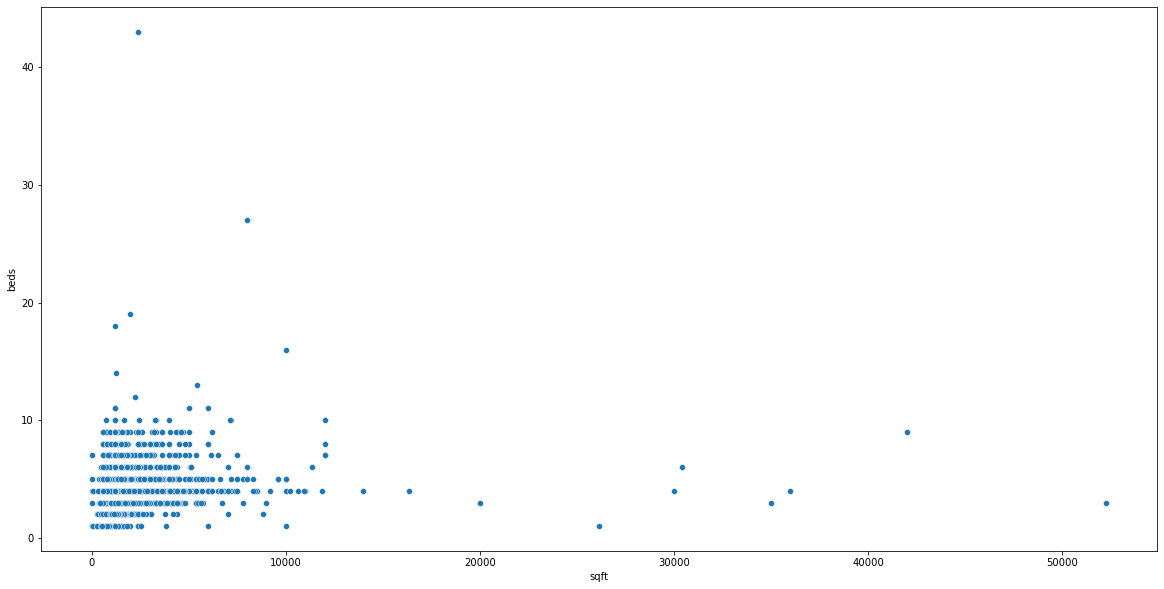

In [823]:
sns.scatterplot(y = "beds", x = "sqft", data = df)

The scatterplot shows us that there are some outliers in both dimensions.<br>
It is unlikely for a property to have 20k sqft or more than 10 beds.

In [824]:
df['beds'].value_counts().sort_index()

1      640
2     5517
3     4818
4     1390
5      349
6      220
7      100
8       88
9       52
10      14
11       4
12       1
13       1
14       1
16       1
18       1
19       1
27       1
43       1
Name: beds, dtype: int64

In [825]:
# Given the small number of properties with 10+ beds, we can drop these to remove the outliers.
df = df[df['beds']<=10]
df['beds'].value_counts().sort_index()

1      640
2     5517
3     4818
4     1390
5      349
6      220
7      100
8       88
9       52
10      14
Name: beds, dtype: int64

Now we examine sqft to determine if there are any outliers that may skew the analysis.

In [826]:
df['sqft'].describe()

count    13188.000000
mean      1553.237014
std       1232.934578
min          1.000000
25%       1100.000000
50%       1275.000000
75%       1670.000000
max      52272.000000
Name: sqft, dtype: float64

In [827]:
q1 = df['sqft'].quantile(0.25)
q3 = df['sqft'].quantile(0.75)
iqr = q3 - q1
min_val = max([q1 - (1.5 * iqr), 0])
max_val = q3 + (1.5 * iqr)
num_less_min = df[df['sqft']<min_val].shape[0]
num_gtr_max = df[df['sqft']>max_val].shape[0]
print(f'Lower quartile: {q1},\nUpper quartile:{q3},\nIQR:{iqr}\nMin:{min_val}\nMax:{max_val}')
print(f'Number of properties with sqft less than {min_val}: {num_less_min}')
print(f'Number of properties with sqft more than {max_val}: {num_gtr_max}')

Lower quartile: 1100.0,
Upper quartile:1670.0,
IQR:570.0
Min:245.0
Max:2525.0
Number of properties with sqft less than 245.0: 7
Number of properties with sqft more than 2525.0: 1138


From our high level analysis, we determined the min and max values for properties in line with that of a boxplot. <br>
    7 properties with less than the min val<br>
    1138 with greater than the max val<br>
It seems unlikely that approx 10% of all properties would be outliers so we can look a little more closely at the properties with sqft abover 2525.

Looking at the distributions of each dimension, 75% of properties above 2525 sqft are below 4025 and 90% are below 5209.<br>
For the purposes of this analysis, we will exclude the 10% above 5209.

              bath      balcony        price         beds          sqft  \
count  1138.000000  1138.000000  1138.000000  1138.000000   1138.000000   
mean      4.507909     1.528998   377.893453     4.211775   4016.924341   
std       1.423026     1.139961   356.485805     1.255406   3027.519724   
min       1.000000     0.000000    40.000000     1.000000   2526.000000   
25%       4.000000     0.000000   200.000000     4.000000   2981.875000   
50%       4.000000     2.000000   280.000000     4.000000   3432.500000   
75%       5.000000     2.000000   420.000000     4.000000   4025.000000   
max      14.000000     3.000000  3600.000000    10.000000  52272.000000   

         price_sqft  
count   1138.000000  
mean    9517.181458  
std     6072.479407  
min      267.829813  
25%     5717.862065  
50%     7988.186883  
75%    11369.789957  
max    76530.612245  
bath              6.000000
balcony           3.000000
price           660.000000
beds              6.000000
sqft           520

array([[<AxesSubplot:title={'center':'bath'}>,
        <AxesSubplot:title={'center':'balcony'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'beds'}>],
       [<AxesSubplot:title={'center':'sqft'}>,
        <AxesSubplot:title={'center':'price_sqft'}>]], dtype=object)

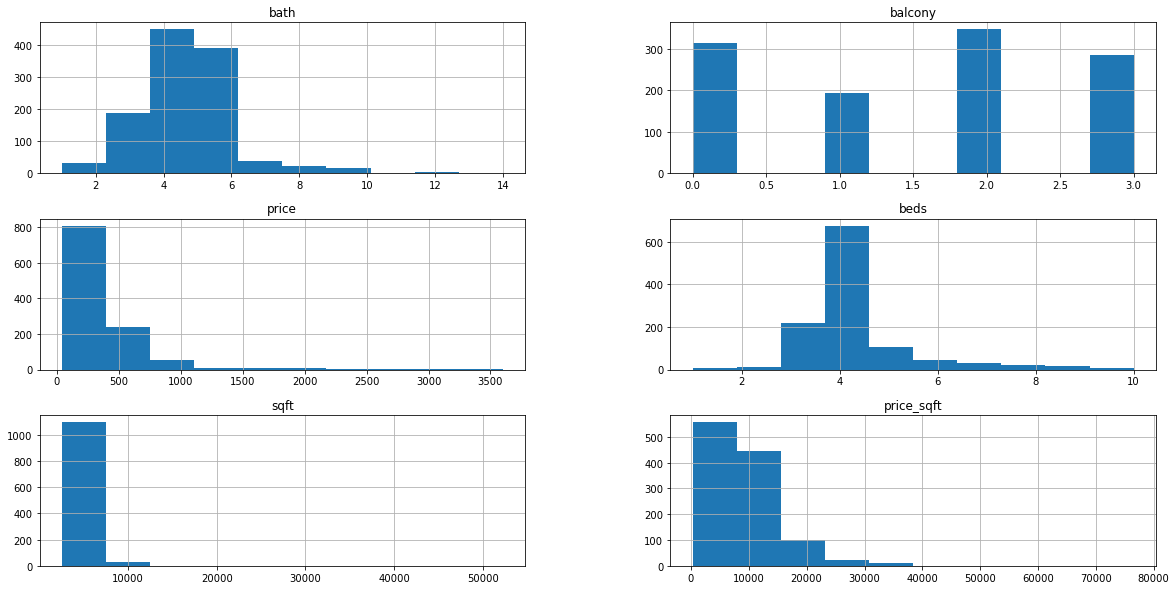

In [828]:
print(df[df['sqft']>2525].describe())
print(df[df['sqft']>2525].quantile(0.9))
df[df['sqft']>2525].hist()

In [829]:
# Removing the 7 properties below the min and all properties above 90% quantile for outliers.
upper_cut = df[df['sqft']>2525]['sqft'].quantile(0.9)
df = df[np.logical_and(df['sqft'] > min_val, df['sqft'] < upper_cut)]

<AxesSubplot:>

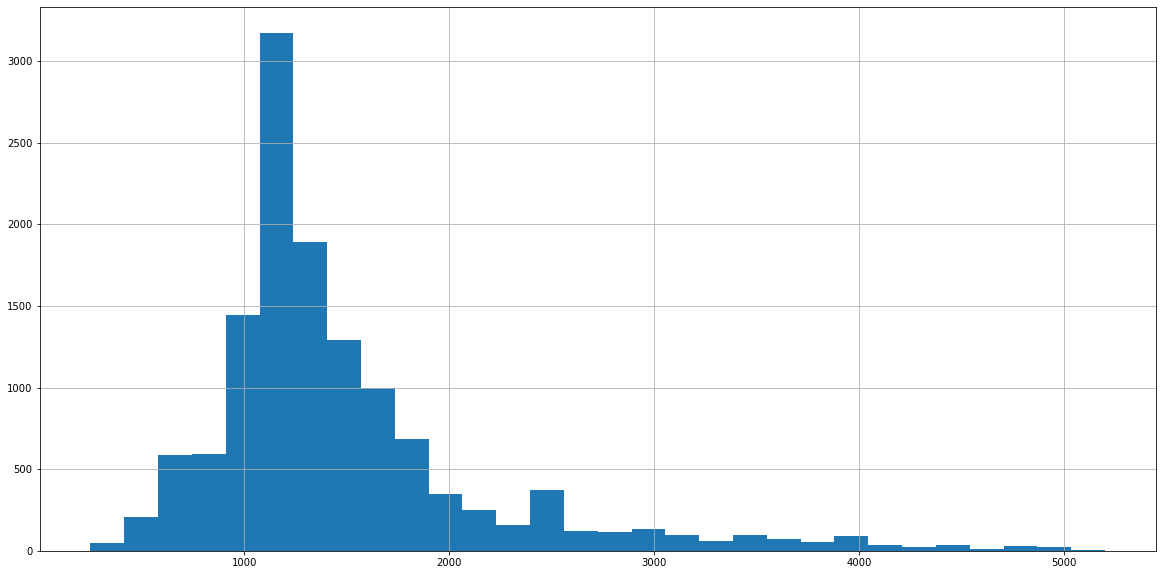

In [830]:
df['sqft'].hist(bins = 30)

C:\Users\Liam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sqft'>

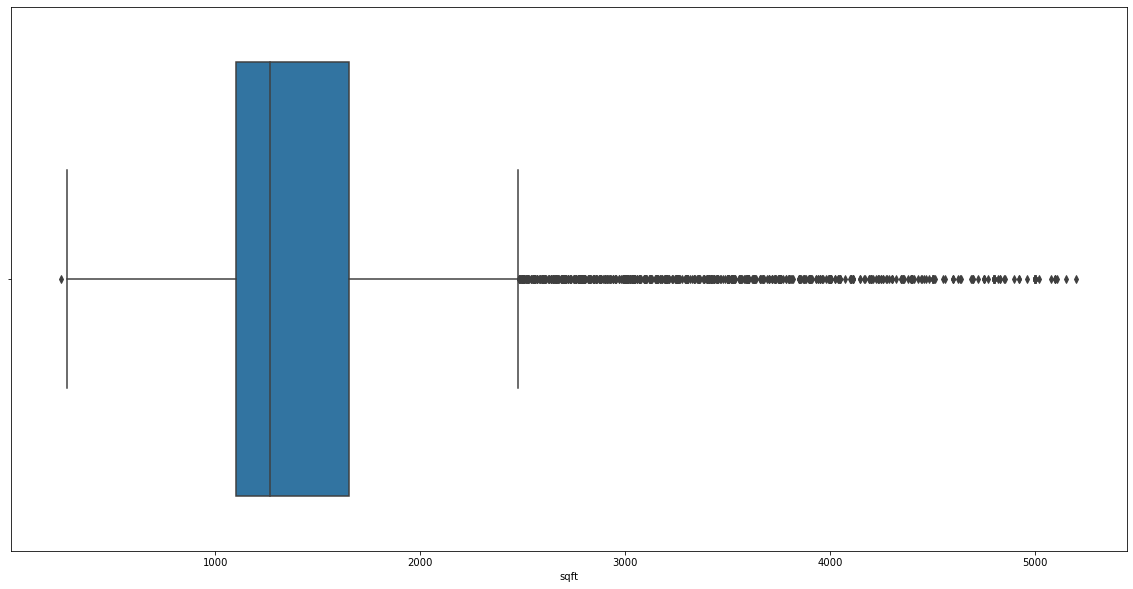

In [831]:
sns.boxplot(df['sqft'])

In [832]:
# Adding a dimension - approx avg sqft per bed
df['approx_sqft_bed'] = df['sqft']/df['beds']

array([[<AxesSubplot:title={'center':'approx_sqft_bed'}>]], dtype=object)

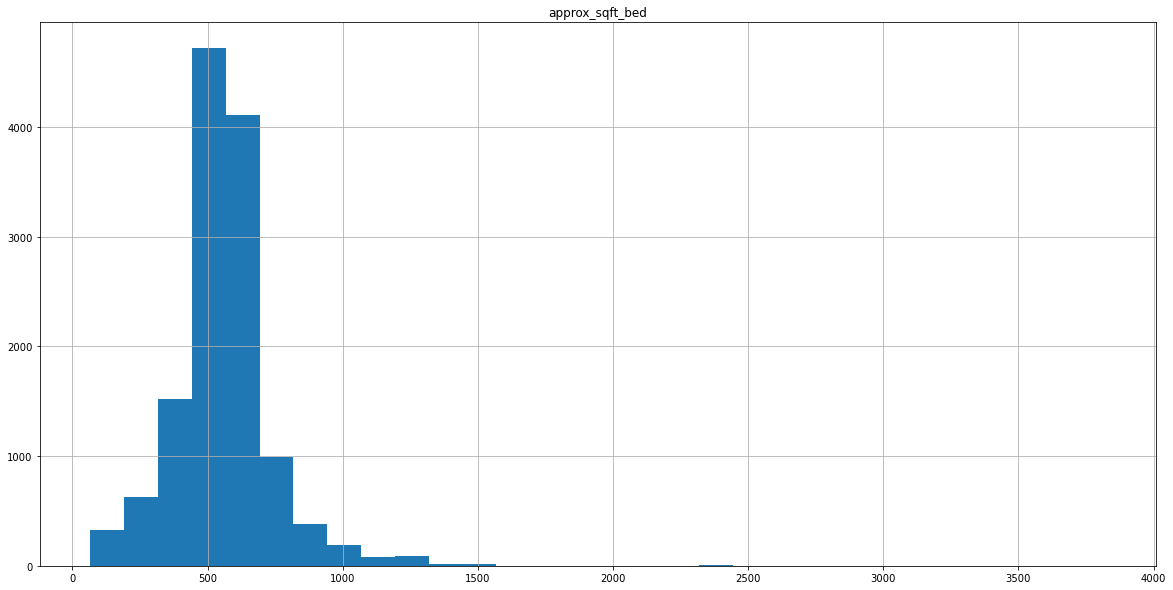

In [833]:
df.hist('approx_sqft_bed', bins = 30)

array([[<AxesSubplot:title={'center':'price_sqft'}>]], dtype=object)

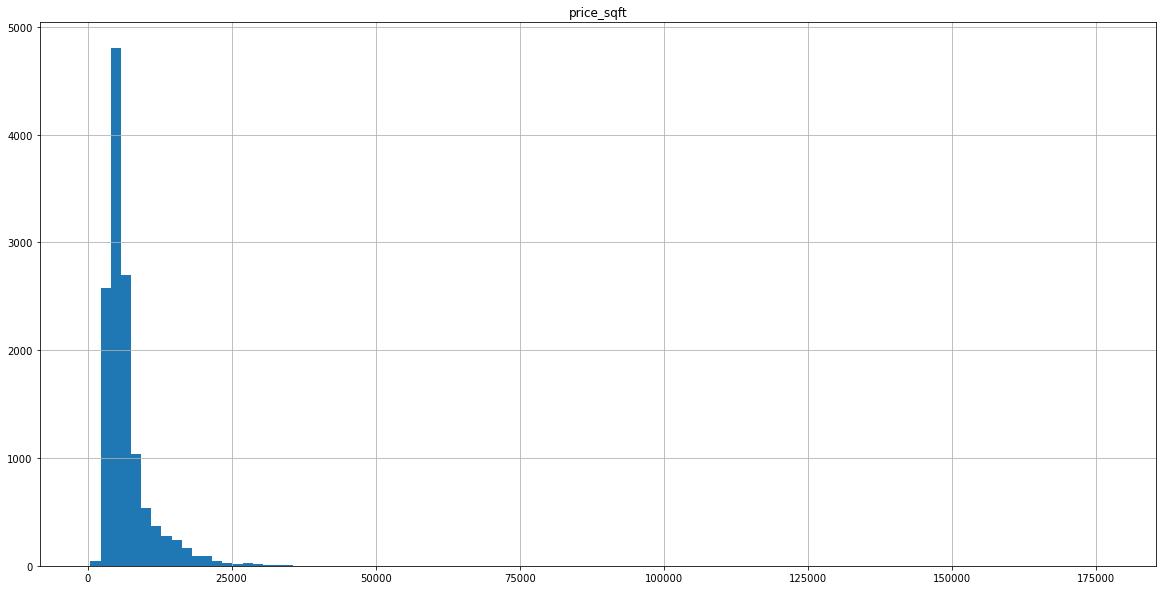

In [834]:
df.hist('price_sqft', bins = 100)

After removing the outliers in the sqft dimension, we will examine the relationship between sqft & price. <br>
As we can see there is a long tail for price_sqft suggesting that, since we have removed the outliers for sqft, we have further outlier in the price dimension.

count     13067.000000
mean       6646.679825
std        4466.231695
min         500.000000
25%        4262.948207
50%        5416.666667
75%        7270.243418
max      176470.588235
Name: price_sqft, dtype: float64


C:\Users\Liam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price_sqft'>

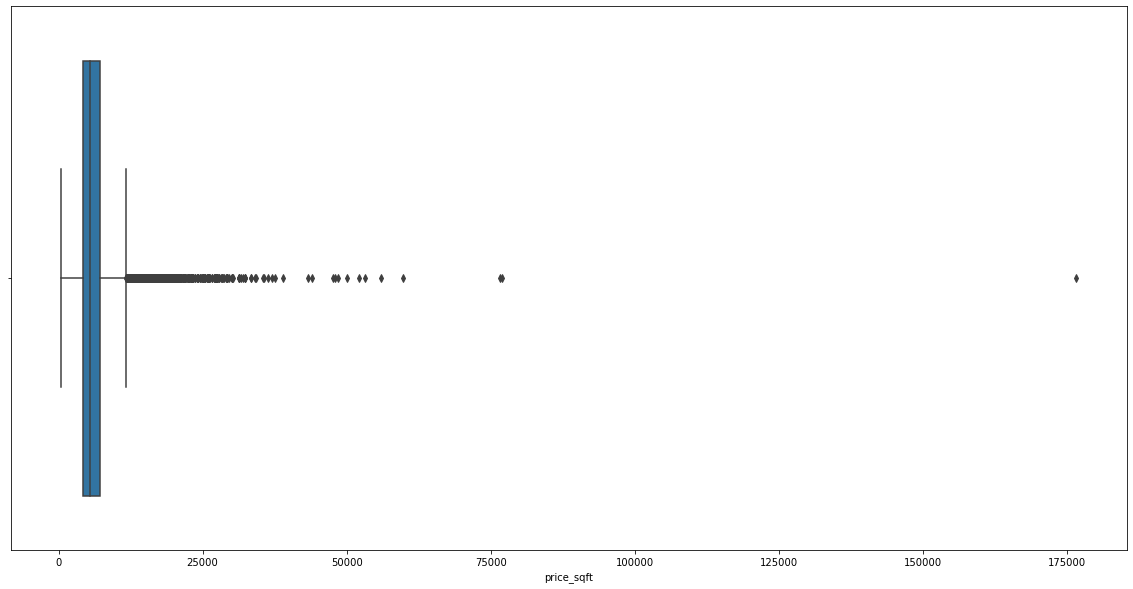

In [835]:
print(df['price_sqft'].describe())
sns.boxplot(df['price_sqft'])

<AxesSubplot:xlabel='price', ylabel='sqft'>

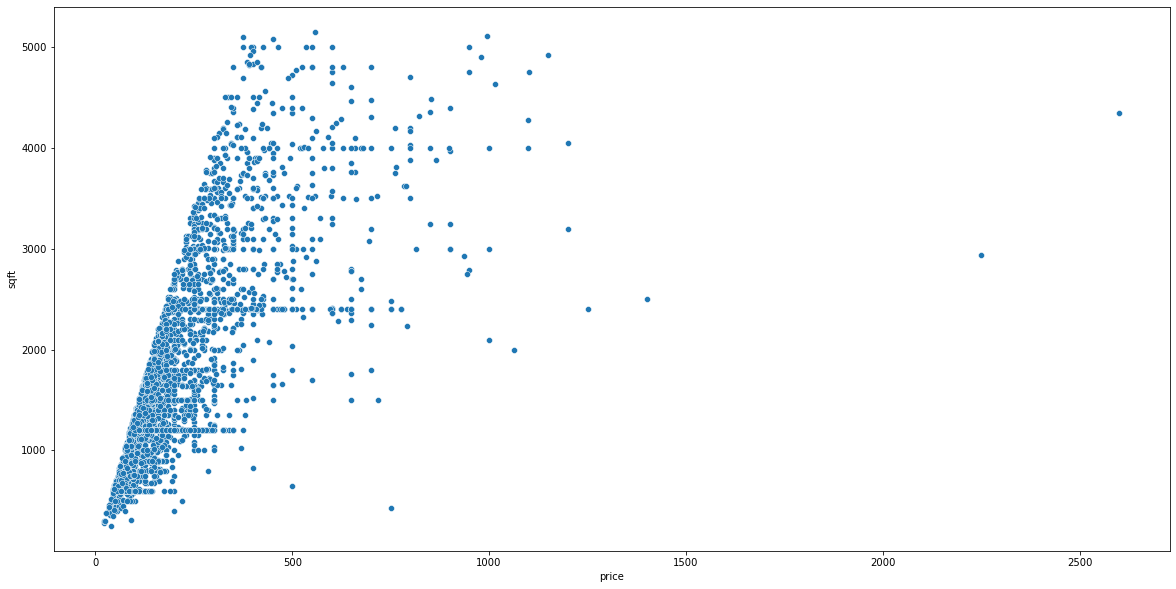

In [836]:
sns.scatterplot(x = "price", y = "sqft", data = df[df['price_sqft']>7270])

<AxesSubplot:xlabel='price_sqft', ylabel='sqft'>

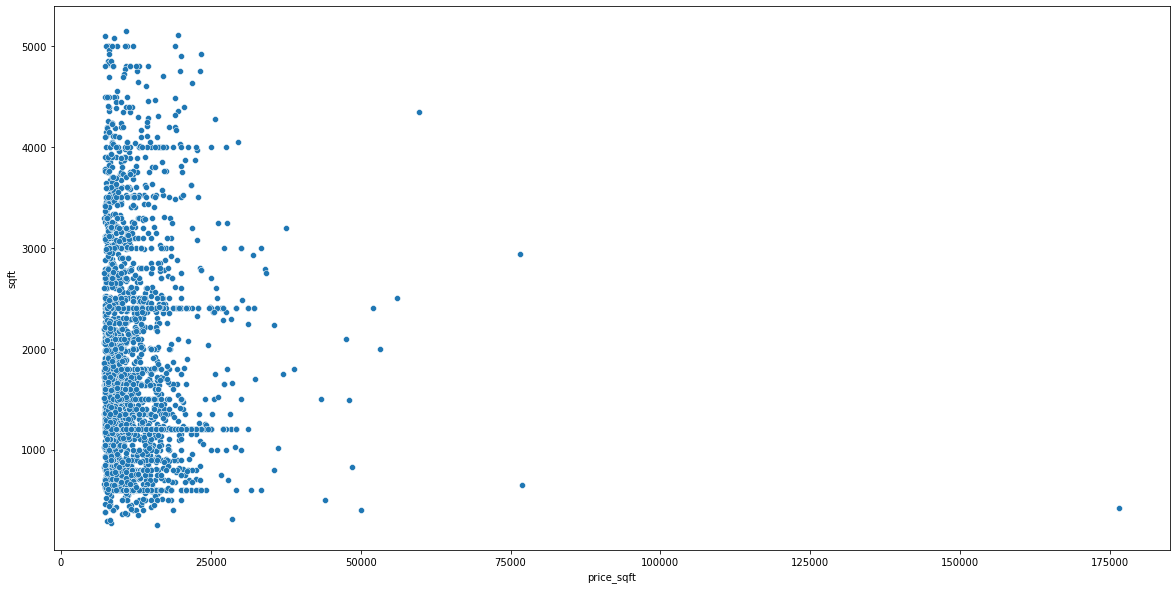

In [837]:
sns.scatterplot(x = "price_sqft", y = "sqft", data = df[df['price_sqft']>7270])

<AxesSubplot:xlabel='price_sqft', ylabel='price'>

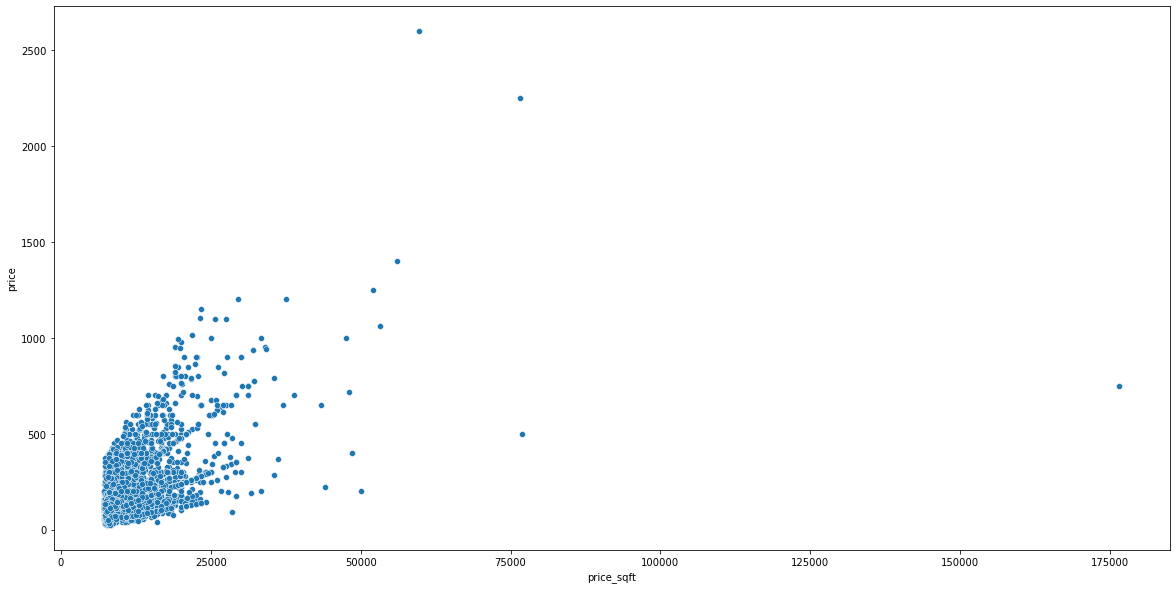

In [838]:
sns.scatterplot(x = "price_sqft", y = "price", data = df[df['price_sqft']>7270])

In [839]:
print(df[df['price_sqft']>7270].describe())
print(df[df['price_sqft']>7270]['price_sqft'].quantile(0.975))
print(df[df['price_sqft']>7270]['price_sqft'].quantile(0.99))

              bath      balcony        price         beds         sqft  \
count  3267.000000  3267.000000  3267.000000  3267.000000  3267.000000   
mean      3.558923     1.500459   214.933901     3.606367  1812.359302   
std       1.596595     0.970595   163.941211     1.528439   961.980761   
min       1.000000     0.000000    22.890000     1.000000   250.000000   
25%       3.000000     1.000000   115.000000     3.000000  1200.000000   
50%       3.000000     2.000000   165.000000     3.000000  1560.000000   
75%       4.000000     2.000000   260.000000     4.000000  2400.000000   
max      14.000000     3.000000  2600.000000    10.000000  5150.000000   

          price_sqft  approx_sqft_bed  
count    3267.000000      3267.000000  
mean    11971.517114       555.295249  
std      6152.251111       283.839865  
min      7272.727273        66.666667  
25%      8181.818182       320.000000  
50%     10200.000000       569.800000  
75%     13988.624123       705.625000  
max    176470

We can see that there are some extreme values in price per sqft, however, the relationship between price & sqft seems to be quite linear, with only a small number of the extreme values appearing to be extreme enough to exclude.<br>
Using the 97.5% quartile as the cut off point, will allow us to maintain values that are extreme but also keep in enough variability at the higher end of the market.

In [840]:
price_cutoff = df[df['price_sqft']>7270]['price_sqft'].quantile(0.975)
df = df[df['price_sqft'] < price_cutoff]

array([[<AxesSubplot:title={'center':'bath'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'sqft'}>,
        <AxesSubplot:title={'center':'price_sqft'}>],
       [<AxesSubplot:title={'center':'approx_sqft_bed'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

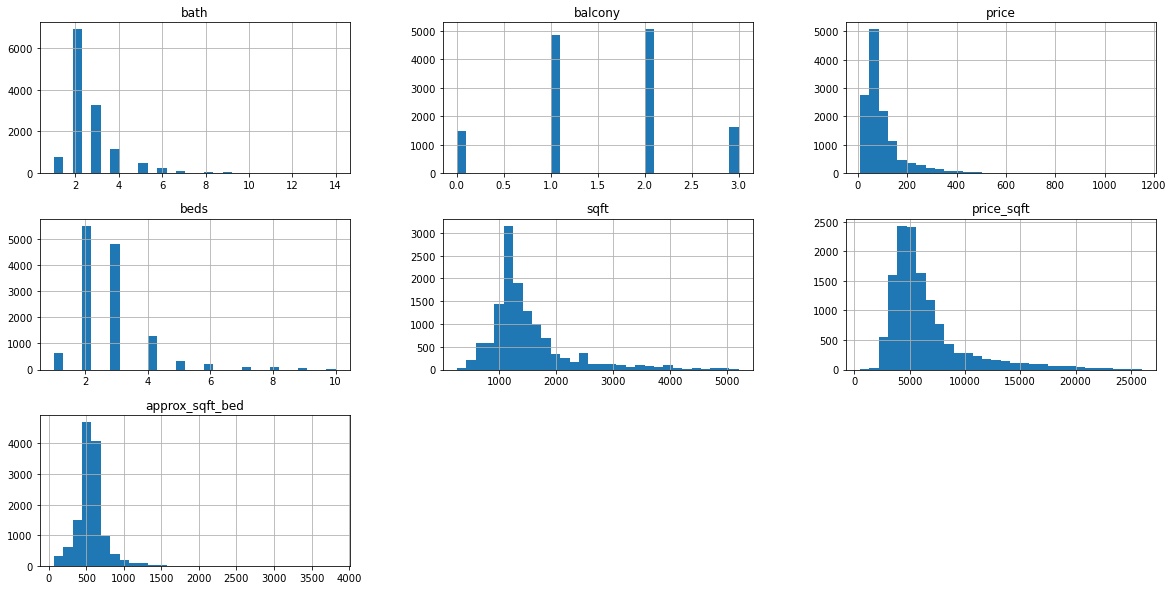

In [841]:
df.hist(bins = 30)

We now need to examine is the approx_sqft_bed dimension.<br>
Research indicates that the average bedroom size is in the region of 200sqft with 100sqft as a lower end estimate.<br>
Given the properties listed also account for bath, kitchen and hall area in there sqft measure, any values significantly lower than 200 should be excluded to account for this.<br>
We will then examine the higher end values to justifiy if they should be included.

count    12985.000000
mean       558.537698
std        179.930404
min         66.666667
25%        473.333333
50%        551.000000
75%        623.000000
max       3820.000000
Name: approx_sqft_bed, dtype: float64


C:\Users\Liam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='approx_sqft_bed'>

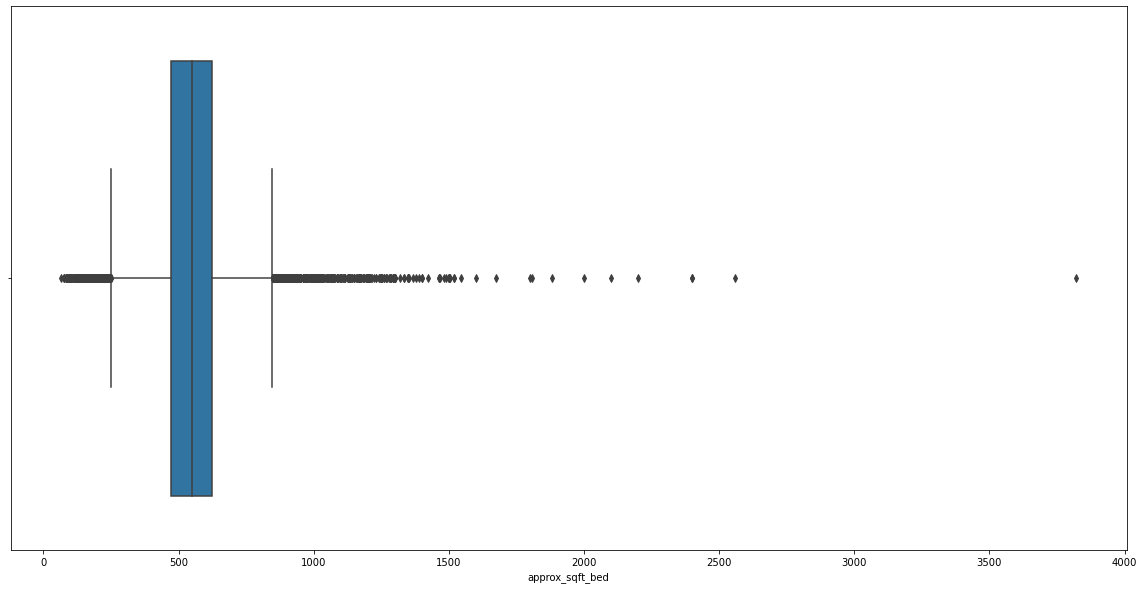

In [842]:
print(df['approx_sqft_bed'].describe())
sns.boxplot(df['approx_sqft_bed'])

<AxesSubplot:>

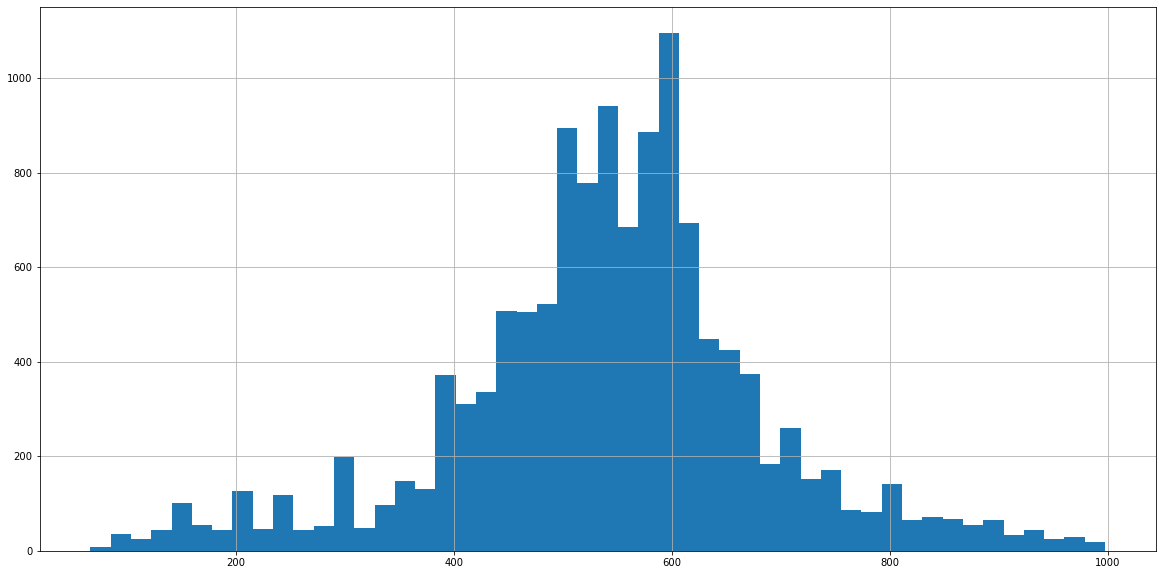

In [843]:
df[df['approx_sqft_bed']<1000]['approx_sqft_bed'].hist(bins = 50)

We can see that there are small amount of properties with approx_sqft_bed < 200 so we can eclude these.

In [844]:
df = df[df['approx_sqft_bed']>200]

count    12569.000000
mean       571.772711
std        167.147964
min        201.600000
25%        483.333333
50%        557.500000
75%        625.000000
max       3820.000000
Name: approx_sqft_bed, dtype: float64


C:\Users\Liam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='approx_sqft_bed'>

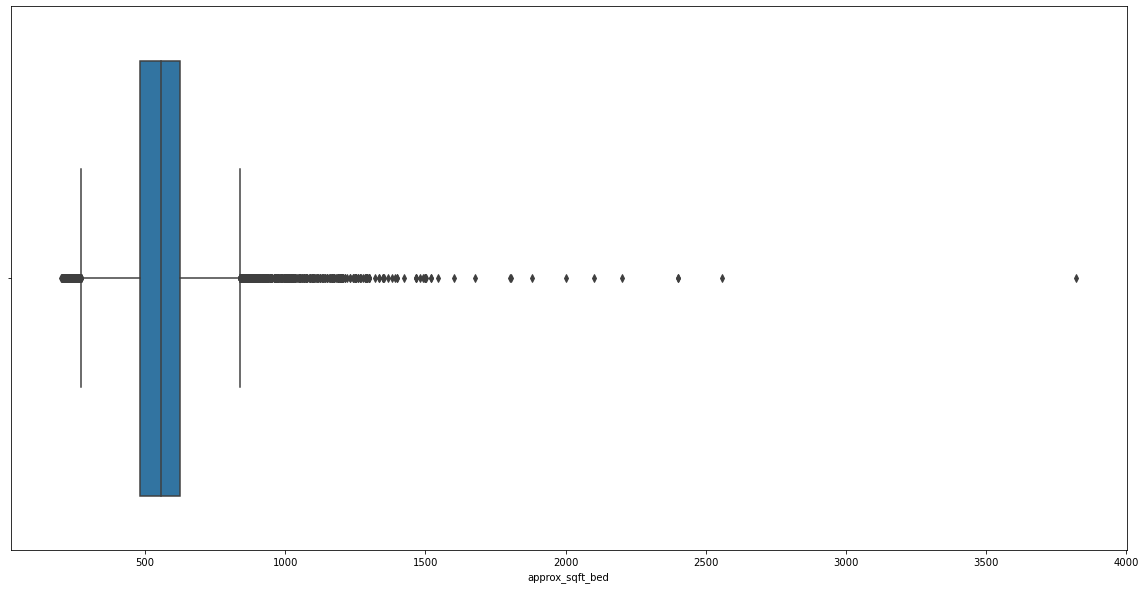

In [845]:
print(df['approx_sqft_bed'].describe())
sns.boxplot(df['approx_sqft_bed'])

In [846]:
sqft_bed_cutoff = df['approx_sqft_bed'].quantile(0.99)
print(sqft_bed_cutoff)

1200.0


In [847]:
#Using the 99% quantile, we exclude the very highest sqft_bed properties
df = df[df['approx_sqft_bed']<sqft_bed_cutoff]

array([[<AxesSubplot:title={'center':'bath'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'sqft'}>,
        <AxesSubplot:title={'center':'price_sqft'}>],
       [<AxesSubplot:title={'center':'approx_sqft_bed'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

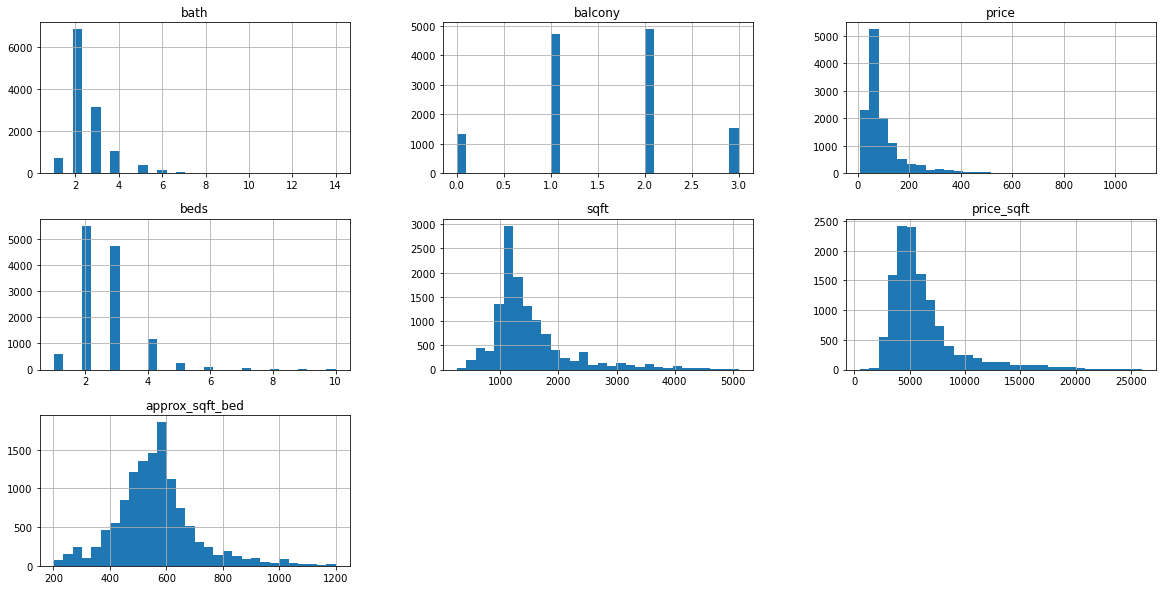

In [848]:
df.hist(bins = 30)

Now we examine price.

<AxesSubplot:>

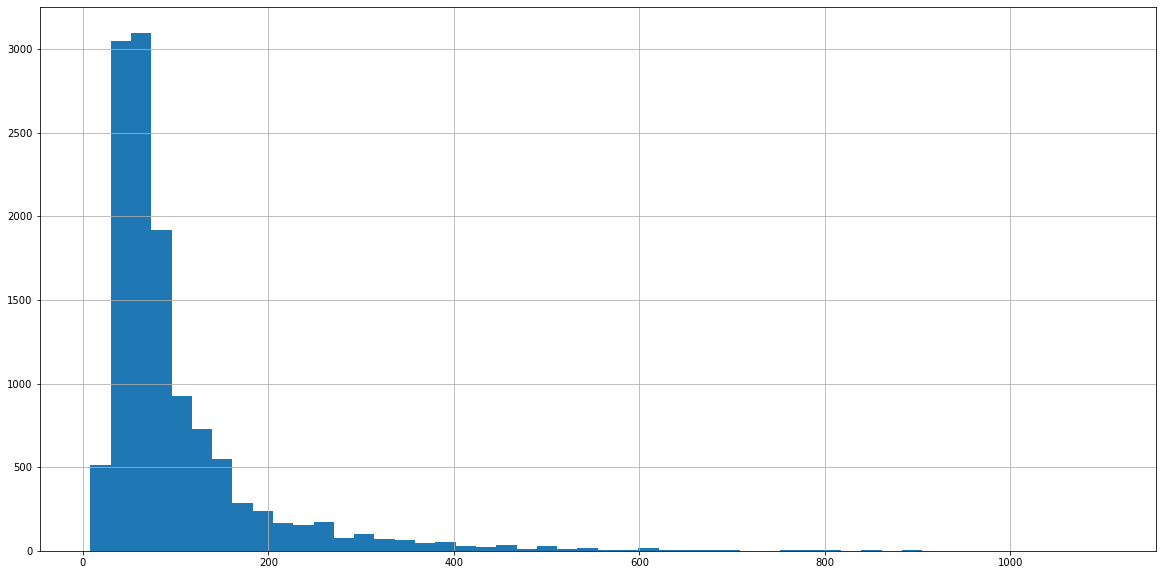

In [849]:
df['price'].hist(bins = 50)

In [850]:
df['price'].describe()

count    12438.000000
mean        98.877261
std         90.211156
min          8.000000
25%         49.000000
50%         69.500000
75%        111.750000
max       1102.000000
Name: price, dtype: float64

<AxesSubplot:>

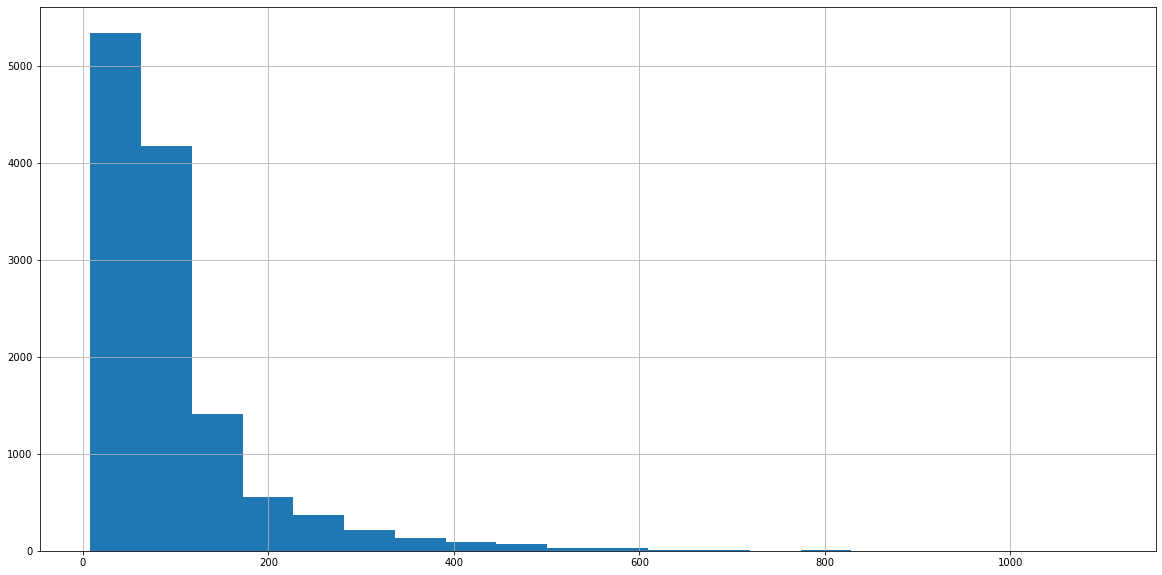

In [851]:
df['price'].hist(bins = 20)

In [852]:
count, division = np.histogram(df['price'], bins = 20)

In [853]:
price_df = pd.DataFrame({"Count": count,"Division": division[:-1]})
price_df

,Count,Division
0,5335,8.0
1,4175,62.7
2,1413,117.4
3,551,172.1
4,366,226.8
5,213,281.5
6,133,336.2
7,87,390.9
8,70,445.6
9,30,500.3


In [854]:
price_df[price_df['Division']>693.2]['Count'].sum()

20

20 properties are above 693.2 so we will exclude

In [855]:
df = df[df["price"]<=693.2]

The final dimension will examine is bath.

In [856]:
df['bath'].describe()

count    12412.000000
mean         2.554463
std          1.057838
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: bath, dtype: float64

In [857]:
df['bath'].value_counts().sort_index()

1.0      736
2.0     6837
3.0     3157
4.0     1033
5.0      386
6.0      168
7.0       46
8.0       24
9.0       19
10.0       2
12.0       3
14.0       1
Name: bath, dtype: int64

For the purposes of this analysis, we do not need to consider properties with > 6 bathrooms.<br>
This would only represent a tiny minority of properties so we can safely exclude from our data.

In [858]:
df = df[df['bath']<=6]

array([[<AxesSubplot:title={'center':'bath'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'price'}>],
       [<AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'sqft'}>,
        <AxesSubplot:title={'center':'price_sqft'}>],
       [<AxesSubplot:title={'center':'approx_sqft_bed'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

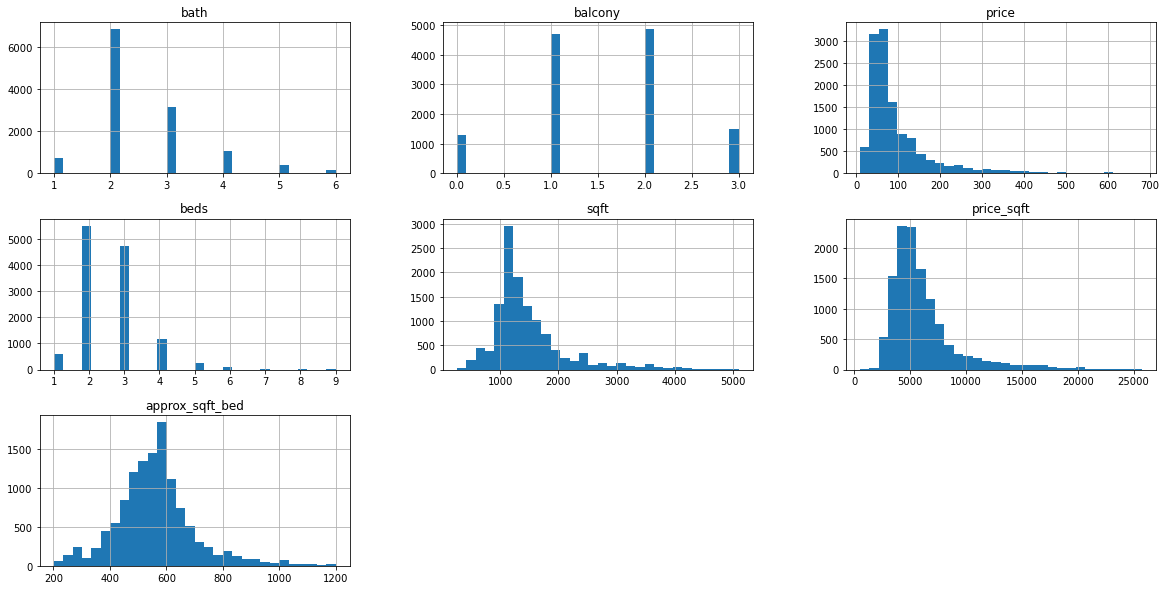

In [859]:
df.hist(bins = 30)

#### Data visualisation and data validation - deriving further inisghts.
After performing some feature engineering to remove obvious outliers, we can now look a little closer at the data to derive more insight.

In [860]:
# Function to build a scatterplot for 1, 2, 3, 4 bed properties in various locations.
def plot_scatter(df, location):
    bed1 = df[np.logical_and(df['location'] == location, df['beds'] == 1)]
    bed2 = df[np.logical_and(df['location'] == location, df['beds'] == 2)]
    bed3 = df[np.logical_and(df['location'] == location, df['beds'] == 3)]
    bed4 = df[np.logical_and(df['location'] == location, df['beds'] == 4)]
              
    matplotlib.rcParams['figure.figsize'] = (8, 6)
    
    plt.scatter(bed1['sqft'], bed1['price'], color = 'blue', label = '1 bed', s = 50)
    plt.scatter(bed2['sqft'], bed2['price'], color = 'green', label = '2 bed', s = 50, marker = '+')
    plt.scatter(bed3['sqft'], bed3['price'], color = 'red', label = '3 bed', s = 50, marker = 'x')
    plt.scatter(bed4['sqft'], bed4['price'], color = 'black', label = '4 bed', s = 50, marker = '*')
    
    plt.xlabel("Total Area (sq ft)")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()


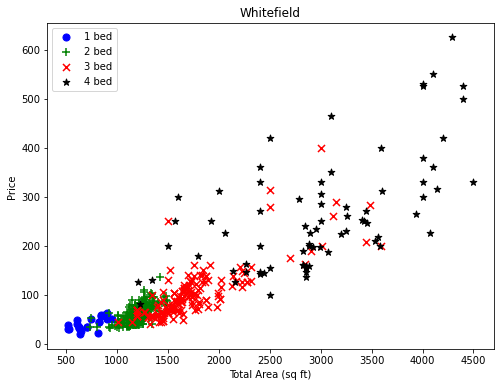

In [861]:
plot_scatter(df, "Whitefield")

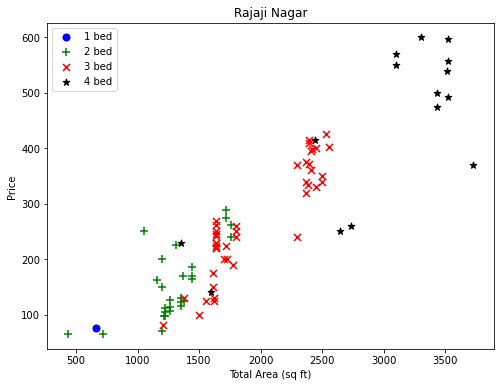

In [862]:
plot_scatter(df, "Rajaji Nagar")

Text(0.5, 1.0, 'Bed vs Sq Ft Boxplot')

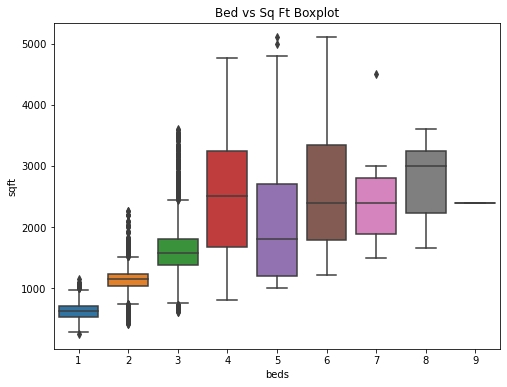

In [863]:
sns.boxplot(x='beds', y = 'sqft', data = df)
plt.title("Bed vs Sq Ft Boxplot")

Text(0.5, 1.0, 'Bed vs Price Boxplot')

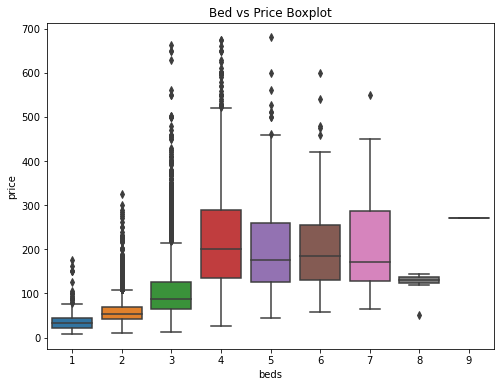

In [864]:
sns.boxplot(x='beds', y = 'price', data = df)
plt.title("Bed vs Price Boxplot")

In [865]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12317 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area_type        12317 non-null  object 
 1   location         12317 non-null  object 
 2   bath             12317 non-null  float64
 3   balcony          12317 non-null  float64
 4   price            12317 non-null  float64
 5   beds             12317 non-null  int64  
 6   sqft             12317 non-null  float64
 7   price_sqft       12317 non-null  float64
 8   approx_sqft_bed  12317 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.3+ MB


At this point, we need to address the categorical variables in our data. <br>
We will one hot encode location and drop area_type - as this is correlated with location.

In [866]:
dummies_location = pd.get_dummies(df['location'])
df.drop(['area_type'], axis = 'columns', inplace = True)

Since there are 2.5k observations with other as the location, we will drop these from the data as
having this as an identifier will not add any predictive value to our model.

In [867]:
dummies_location = dummies_location.drop('Other', axis = 'columns')

In [868]:
# Joining up the dataframes and removing the dimensions that have been one hot encoded.
df = pd.concat([df, dummies_location], axis = 'columns')

In [869]:
df = df.drop(['location'], axis = 'columns')

In [870]:
print(df.head())

   bath  balcony   price  beds    sqft   price_sqft  approx_sqft_bed  \
0   2.0      1.0   39.07     2  1056.0  3699.810606            528.0   
1   5.0      3.0  120.00     4  2600.0  4615.384615            650.0   
2   2.0      3.0   62.00     3  1440.0  4305.555556            480.0   
3   3.0      1.0   95.00     3  1521.0  6245.890861            507.0   
4   2.0      1.0   51.00     2  1200.0  4250.000000            600.0   

   1st Block Jayanagar  1st Phase JP Nagar  2nd Phase Judicial Layout  ...  \
0                    0                   0                          0  ...   
1                    0                   0                          0  ...   
2                    0                   0                          0  ...   
3                    0                   0                          0  ...   
4                    0                   0                          0  ...   

   Vijayanagar  Vishveshwarya Layout  Vishwapriya Layout  Vittasandra  \
0            0           

In [871]:
df.dtypes.value_counts()

uint8      240
float64      6
int64        1
dtype: int64

Now that we have our features prepared and all of the dimensions in numerical form,<br> we can
begin to model the data.

In [872]:
# Separate our data into predictors (X) and target (Y) where price is the target variable.
X = df.drop('price', axis = 'columns')
y = df['price']

In [873]:
X.head(10)

,bath,balcony,beds,sqft,price_sqft,approx_sqft_bed,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2.0,1.0,2,1056.0,3699.810606,528.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.0,3.0,4,2600.0,4615.384615,650.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,3.0,3,1440.0,4305.555556,480.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,1.0,3,1521.0,6245.890861,507.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,2,1200.0,4250.000000,600.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,1.0,2,1170.0,3247.863248,585.000000,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,4.0,0.0,4,2732.0,7467.057101,683.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,4.0,0.0,4,3300.0,18181.818182,825.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3.0,1.0,3,1310.0,4828.244275,436.666667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2.0,2.0,3,1800.0,3888.888889,600.000000,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


As price_sqft & approx_sqft_bed are derived from existing features, we can remove these as they are highly correlated.

                     bath   balcony      beds      sqft  price_sqft  \
bath             1.000000  0.156171  0.836347  0.735181    0.413673   
balcony          0.156171  1.000000  0.155486  0.154591   -0.013293   
beds             0.836347  0.155486  1.000000  0.683656    0.384287   
sqft             0.735181  0.154591  0.683656  1.000000    0.296504   
price_sqft       0.413673 -0.013293  0.384287  0.296504    1.000000   
approx_sqft_bed  0.134865  0.042310 -0.097182  0.619313    0.059207   

                 approx_sqft_bed  
bath                    0.134865  
balcony                 0.042310  
beds                   -0.097182  
sqft                    0.619313  
price_sqft              0.059207  
approx_sqft_bed         1.000000  


<AxesSubplot:>

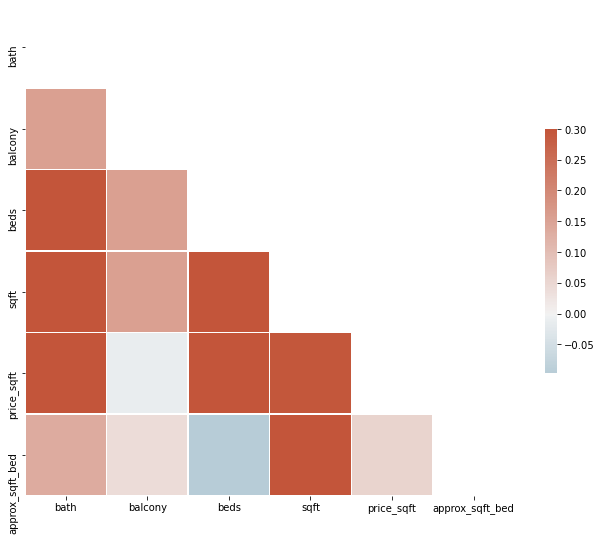

In [874]:
# Compute the correlation matrix
corr = df[['bath', 'balcony', 'beds', 'sqft', 'price_sqft', 'approx_sqft_bed']].corr()
print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [875]:
X = df.drop(['price_sqft', 'approx_sqft_bed', 'price'], axis = 'columns')

In [876]:
X.head()

,bath,balcony,beds,sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2.0,1.0,2,1056.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.0,3.0,4,2600.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,3.0,3,1440.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,1.0,3,1521.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,2,1200.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [877]:
X.shape

(12317, 244)

In [878]:
y.shape

(12317,)

Split the data into training and testing datasets.

In [879]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [880]:
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.6808828962056015

Now we perform 5 fold cross validation

In [881]:
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
cross_val_score(LinearRegression(), X, y, cv = cv)

array([0.66496263, 0.67709186, 0.6805573 , 0.66941   , 0.66802389])

Now, using GridSearch cross validation, we can compare 3 different Regression models.
    <t><li> 1. Linear Regression
    <t><li> 2. Lasso Regression
    <t><li> 3. Decision Tree Regression

In [882]:
# Build out our model and hyperparameter dictionaries for use with GridSearch
def find_best_model_using_gridseachcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]                    
            }
        },
        'lasso': {
            'model': Lasso(),
            'params':{
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv = cv, return_train_score = False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_, 
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])

In [883]:
find_best_model_using_gridseachcv(X, y)

,model,best_score,best_params
0,linear_regression,0.672009,{'normalize': True}
1,lasso,0.601873,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.508763,"{'criterion': 'mse', 'splitter': 'random'}"


Now that we have determined the best model configuration to predict house price using the decision tree, we will build a function to predict the price of a new entry.

In [884]:
X.head()

,bath,balcony,beds,sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2.0,1.0,2,1056.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.0,3.0,4,2600.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,3.0,3,1440.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,1.0,3,1521.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,2,1200.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [885]:
def predict_price(location, sqft, bath, balcony, beds):
    loc_index = np.where(X.columns == location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = bath
    x[1] = balcony
    x[2] = beds
    x[3] = sqft
    if loc_index >= 0:
        x[loc_index] = 1
    return lr_clf.predict([x])

In [886]:
predict_price('Vijayanagar', 1000, 1, 2, 2)

array([49.4489852])

In [887]:
predict_price('Whitefield', 1000, 1, 2, 2)

array([28.61642635])

In [888]:
predict_price('Rajaji Nagar', 1000, 1, 2, 2)

array([161.94846596])